# Effective area to muon tracks

In [14]:
import numpy as np
import h5py
from matplotlib import pyplot as plt

In [44]:
with h5py.File("aeff_input_tracks/effective_area.h5", 'r') as f:
    area10 = f['2010/nu_mu/area'][()]
    bin_edges_0 = f['2010/nu_mu/bin_edges_0'][()]
    bin_edges_1 = f['2010/nu_mu/bin_edges_1'][()]

In [49]:
bin_edges_0

array([1.00000000e+02, 1.05925373e+02, 1.12201845e+02, 1.18850223e+02,
       1.25892541e+02, 1.33352143e+02, 1.41253754e+02, 1.49623566e+02,
       1.58489319e+02, 1.67880402e+02, 1.77827941e+02, 1.88364909e+02,
       1.99526231e+02, 2.11348904e+02, 2.23872114e+02, 2.37137371e+02,
       2.51188643e+02, 2.66072506e+02, 2.81838293e+02, 2.98538262e+02,
       3.16227766e+02, 3.34965439e+02, 3.54813389e+02, 3.75837404e+02,
       3.98107171e+02, 4.21696503e+02, 4.46683592e+02, 4.73151259e+02,
       5.01187234e+02, 5.30884444e+02, 5.62341325e+02, 5.95662144e+02,
       6.30957344e+02, 6.68343918e+02, 7.07945784e+02, 7.49894209e+02,
       7.94328235e+02, 8.41395142e+02, 8.91250938e+02, 9.44060876e+02,
       1.00000000e+03, 1.05925373e+03, 1.12201845e+03, 1.18850223e+03,
       1.25892541e+03, 1.33352143e+03, 1.41253754e+03, 1.49623566e+03,
       1.58489319e+03, 1.67880402e+03, 1.77827941e+03, 1.88364909e+03,
       1.99526231e+03, 2.11348904e+03, 2.23872114e+03, 2.37137371e+03,
      

/Users/fran/.virtualenvs/bayes/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


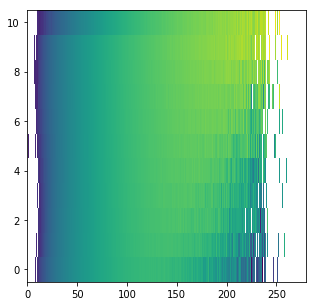

In [48]:
fig, ax = plt.subplots()
fig.set_size_inches((5,5))
ax.imshow(np.log10(np.sum(area10, axis=2)).T, aspect='auto', origin='lower')
